LinearRegression CV MAE: 0.0255
DecisionTree CV MAE: 0.0344
Best model based on CV: LinearRegression
Test MAE: 0.0209


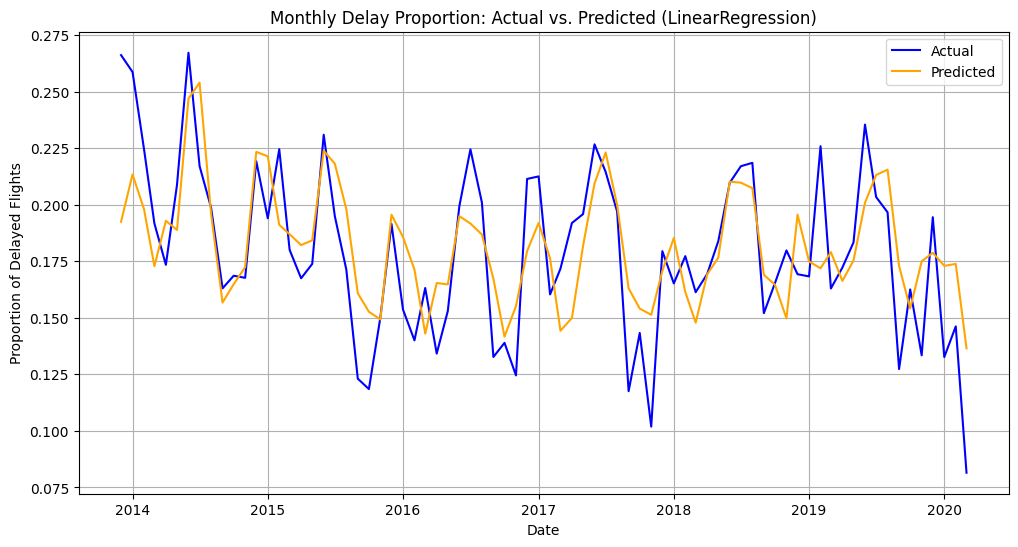

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

# Load the dataset with date parsing
df = pd.read_csv(
    'airline_2m.csv',
    encoding='latin1',
    parse_dates=['FlightDate'],
    low_memory=False
)

# Create binary column for delays > 15 minutes
df['delayed'] = (df['ArrDelayMinutes'] > 15).astype(int)

# Extract year and month for grouping
df['year'] = df['FlightDate'].dt.year
df['month'] = df['FlightDate'].dt.month

# Aggregate by month to get proportion of delayed flights
monthly_delays = df.groupby(['year', 'month'])['delayed'].mean().reset_index()

# Create a date column and set as index
monthly_delays['date'] = pd.to_datetime(monthly_delays['year'].astype(str) + '-' + monthly_delays['month'].astype(str) + '-01')
monthly_delays = monthly_delays.sort_values('date').set_index('date')

# Create lagged features (past 12 months)
for i in range(1, 13):
    monthly_delays[f'lag{i}'] = monthly_delays['delayed'].shift(i)

# Drop rows with NaN values
monthly_delays = monthly_delays.dropna()

# Define features and target
X = monthly_delays[[f'lag{i}' for i in range(1, 13)]]
y = monthly_delays['delayed']

# Train/test split
train_size = int(0.8 * len(monthly_delays))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Set up 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=5, random_state=42)
}

# cross-validation
cv_scores = {}
for name, model in models.items():
    scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)
    cv_scores[name] = np.mean(scores)
    print(f"{name} CV MAE: {cv_scores[name]:.4f}")

# Select and train best model
best_model_name = min(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]
print(f"Best model based on CV: {best_model_name}")
best_model.fit(X_train, y_train)

# Predict on test set
preds_test = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, preds_test)
print(f"Test MAE: {test_mae:.4f}")

# Static plot for test set
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, preds_test, label='Predicted', color='orange')
plt.title(f'Monthly Delay Proportion: Actual vs. Predicted ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Proportion of Delayed Flights')
plt.legend()
plt.grid(True)
plt.show()

# Interactive Plotly graph
fig = go.Figure()

# actual delay proportion trace
fig.add_trace(go.Scatter(
    x=monthly_delays.index,
    y=monthly_delays['delayed'],
    mode='lines',
    name='Actual',
    line=dict(color='blue')
))

# predicted delay proportion trace for test set
fig.add_trace(go.Scatter(
    x=X_test.index,
    y=preds_test,
    mode='lines',
    name='Predicted',
    line=dict(color='orange')
))

# shaded rectangle for test period
test_start = X_test.index[0]
test_end = X_test.index[-1]
fig.add_vrect(
    x0=test_start,
    x1=test_end,
    fillcolor="LightSalmon",
    opacity=0.3,
    layer="below",
    line_width=0
)

# Update layout for interactivity
fig.update_layout(
    title='Monthly Delay Proportion: Actual vs. Predicted (Test Set Shaded)',
    xaxis_title='Date',
    yaxis_title='Proportion of Delayed Flights',
    legend_title='Legend',
    hovermode='x unified',
    template='plotly_white'
)

# Display the interactive plot
fig.show()